In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jr
from jax import vmap, jit

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

import pickle
import matplotlib.pyplot as plt
from functools import partial

2024-11-06 10:46:42.694470: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 10:46:42.694513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 10:46:42.695474: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 10:46:46.214974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/users/amberhu/envs/smooth-rslds/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 3.2.1'. See: https://github.com/urlli

In [3]:
import sys
sys.path.append("data")
from generate_synthetic_data import generate_synthetic_dynamics

sys.path.append("gpslds")
from kernels import Linear, SSL
from transition import SparseGP
from likelihoods import Gaussian
from initialization import initialize_zs
from quadrature import GaussHermiteQuadrature

# Load in synthetic dataset, generate Gaussian emissions

In [20]:
data_path = "data/synthetic_data.pkl"
with open(data_path, 'rb') as f:
    dataset = pickle.load(f)
dt, all_xs, _, _, _ = dataset

In [21]:
# select subset of data for fitting
n_trials = 14
inds_to_select = jnp.concatenate((jnp.arange(int(n_trials/2)), jnp.arange(int(len(all_xs)/2), int(len(all_xs)/2)+int(n_trials/2))))
xs = all_xs[inds_to_select]

n_timesteps = xs.shape[1]
t_max = dt * n_timesteps

In [22]:
# initialize emissions matrices, then generate Gaussian observations
key_sim = jr.PRNGKey(22)
key_C, key_d, key = jr.split(key_sim, 3)

K = 2 # latent dim
D = 30 # number of neurons
C = tfd.Normal(0, 1).sample((D, K), seed=key_C)
d = tfd.Normal(0, 1).sample(D, seed=key_d)
R = 0.25 * jnp.ones(D)

In [23]:
from simulate_data import simulate_gaussian_obs

key, key_dense, key_mask = jr.split(key, 3)
ys_dense = vmap(partial(simulate_gaussian_obs, key_dense, C=C, d=d, R=R))(xs)

In [24]:
# randomly keep some observations with Bernoulli t_mask
p = 0.02
t_mask = tfd.Bernoulli(probs=p).sample((n_trials, n_timesteps), seed=key_mask)
ys_binned = ys_dense * t_mask[:,:,None]

## Plot data and latents

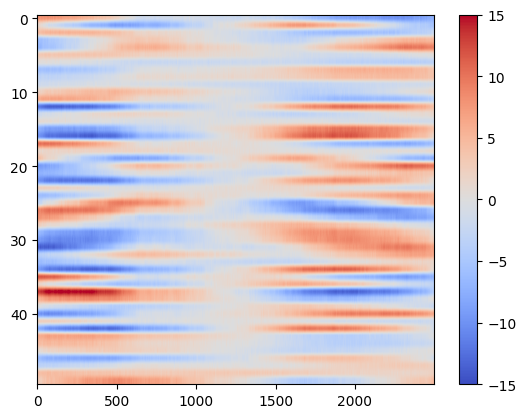

In [8]:
trial_to_show = 0
plt.imshow(ys_binned[trial_to_show].T, aspect='auto', cmap='coolwarm', vmin=-15, vmax=15)
plt.colorbar()

Text(0, 0.5, '$x_2$')

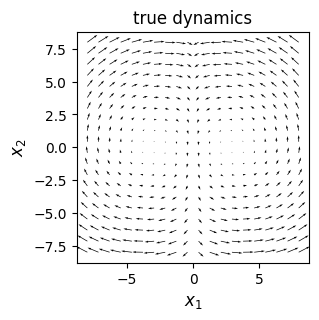

In [9]:
# visualize flow field of true dynamics
xlim = 8
N = 20
X1, X2 = jnp.meshgrid(
    jnp.linspace(-xlim, xlim, N),
    jnp.linspace(-xlim, xlim, N)
)
Xs = jnp.column_stack([X1.ravel(), X2.ravel()]) # (N**2, 2)
f_Xs = vmap(generate_synthetic_dynamics)(Xs)
f_Xs_grid = f_Xs.reshape(N, N, 2)

# plot latent states for first few trials
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.quiver(X1, X2, f_Xs_grid[...,0], f_Xs_grid[...,1], angles='xy')
ax.set_title(f"true dynamics", fontsize=12)
ax.set_xlabel(r"$x_1$", fontsize=12)
ax.set_ylabel(r"$x_2$", fontsize=12)

Text(0, 0.5, '$x_2$')

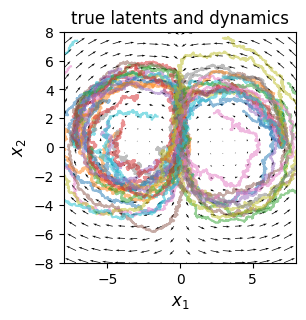

In [10]:
# plot true latent states with true dynamics
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.quiver(X1, X2, f_Xs_grid[...,0], f_Xs_grid[...,1], angles='xy')
for i in range(n_trials):
    ax.plot(xs[i,:,0], xs[i,:,1], alpha=0.5)
ax.set_xlim(-xlim, xlim)
ax.set_ylim(-xlim, xlim)
ax.set_title(f"true latents and dynamics", fontsize=12)
ax.set_xlabel(r"$x_1$", fontsize=12)
ax.set_ylabel(r"$x_2$", fontsize=12)

Text(0, 0.5, '$x_1(t), x_2(t)$')

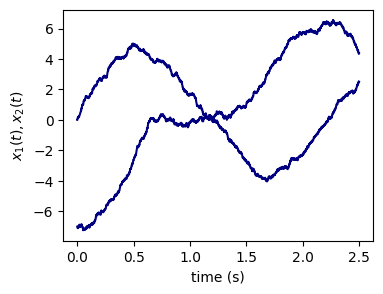

In [11]:
# plot observations for one trial
trial_idx = 0
t_grid = jnp.arange(0, t_max, dt)

fig, ax = plt.subplots(figsize=(4, 3))
for i in range(K):
    ax.plot(t_grid,xs[trial_idx,:,i], color="navy")
ax.set_xlabel("time (s)")
ax.set_ylabel(r"$x_1(t), x_2(t)$")

# Initialize the model

In [26]:
# initialize quadrature object and kernel
gh_quad = GaussHermiteQuadrature(K, n_quad=5)
num_bases = 3
basis_set = lambda x: jnp.array([1., x[0], x[1]]) # decision boundaries of the form: a(1) + b(x[0]) + c(x[1]) = 0
linear_kernel = Linear(gh_quad)
kernel = SSL(gh_quad, linear_kernel, basis_set=basis_set)

# initialize inducing points and function
zs_lim, M_per_dim = 4, 4 # create a 4x4 grid between [-4, 4]^2
zs = initialize_zs(K, zs_lim, M_per_dim)
M = zs.shape[0]
fn = SparseGP(zs, kernel)

# initialize likelihood
t_mask = jnp.ones((n_trials, n_timesteps))
trial_mask = jnp.ones((n_trials, n_timesteps))
likelihood = Gaussian(ys_binned, t_mask)

In [27]:
# initialize kernel hyperparameters
key = jr.PRNGKey(2)
key_W, key_fp = jr.split(key, 2)

num_states = 2
W_init = tfd.Normal(0, 1).sample((num_bases, num_states-1), seed=key_W).astype(jnp.float64) # coefficients for decision boundaries
fp_init = tfd.Normal(0, 1).sample((num_states, K), seed=key_fp).astype(jnp.float64) # parameter of linear kernel
tau_init = 0.5 # smoothness parameter
kernel_params_init = {
    "linear_params": [{"fixed_point": fp_init[i]} for i in range(num_states)],
    "log_tau": jnp.log(tau_init),
    "W": W_init
}

x0_init_params = jnp.zeros((n_trials, K))

# initialize output parameters to true value
output_params_init = {'C': C, 'd': d, 'R': R}

# zero inputs
inputs = jnp.zeros((n_trials, n_timesteps, 1))

# Fit the model

In [ ]:
from em import fit_variational_em

key = jr.PRNGKey(0) # doesn't matter here, since we are using batch_size=n_trials
# n_iters = 25
n_iters = 5
decay, forgetting_rate = 50, -0.9
learning_rates = (decay + jnp.arange(1, 1 + n_iters)) ** (forgetting_rate) # (n_iters,)
result = fit_variational_em(key, 
                            K, 
                            dt, 
                            fn, 
                            likelihood, 
                            trial_mask, 
                            output_params_init,
                            kernel,
                            kernel_params_init, 
                            inputs=None,
                            m0=x0_init_params,
                            mu0=x0_init_params,
                            n_iters=n_iters,
                            n_iters_e=15, 
                            n_iters_m=150, 
                            learning_rates=learning_rates,
                            batch_size=n_trials)

ms, Ss, As, bs, B, q_u_mu, q_u_sigma, output_params, kernel_params, elbos = result

# Debug

In [9]:
from initialization import initialize_vem
I = inputs.shape[-1]
mean_init, var_init = 0., dt * 10
S0, V0, As, bs, ms, Ss, q_u_mu, q_u_sigma, B = initialize_vem(n_trials, n_timesteps, K, M, I, mean_init, var_init)

In [10]:
from em import compute_elbo_all_trials
elbo_fn = lambda ms, Ss: compute_elbo_all_trials(dt, fn, likelihood, trial_mask, ms, Ss, As, bs, inputs, B, output_params_init, kernel, kernel_params_init, q_u_mu, q_u_sigma)

In [11]:
elbo_fn(ms, Ss)

> /home/users/amberhu/gpslds/gpslds/em.py(74)compute_elbo_all_trials()
     72     """Compute ELBO over entire dataset. Used for method evaluation at each vEM iter."""
     73     import pdb; pdb.set_trace()
---> 74     kl_term = vmap(partial(kl_over_time, dt, fn, B=B, q_u_mu=q_u_mu, q_u_sigma=q_u_sigma, kernel=kernel, kernel_params=kernel_params))(trial_mask, ms, Ss, As, bs, inputs).sum()
     75     ell_term = likelihood.ell_over_all_trials(ms, Ss, output_params)
     76     prior_term = fn.prior_term(q_u_mu, q_u_sigma, kernel_params)



ipdb>  n


2024-10-17 18:31:52.274745: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB (rounded to 1228800000)requested by op 
2024-10-17 18:31:52.275008: W external/tsl/tsl/framework/bfc_allocator.cc:497] *******____*******************************************************_____________**************_______
2024-10-17 18:31:52.275101: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2716] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1228800000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.14GiB
              constant allocation:         0B
        maybe_live_out allocation:    1.14GiB
     preallocated temp allocation:         0B
                 total allocation:    2.29GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 1.14GiB
		Operator: op_name="jit(concatenate)/jit(main)/concaten

ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1228800000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.14GiB
              constant allocation:         0B
        maybe_live_out allocation:    1.14GiB
     preallocated temp allocation:         0B
                 total allocation:    2.29GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 1.14GiB
		Operator: op_name="jit(concatenate)/jit(main)/concatenate[dimension=4]" source_file="../gpslds/kernels.py" source_line=167
		XLA Label: fusion
		Shape: f64[30,2500,16,64,2]

	Buffer 2:
		Size: 585.94MiB
		Entry Parameter Subshape: f64[30,2500,16,64,1]

	Buffer 3:
		Size: 585.94MiB
		Entry Parameter Subshape: f64[30,2500,16,64,1]
> /home/users/amberhu/gpslds/gpslds/em.py(74)compute_elbo_all_trials()
     72     """Compute ELBO over entire dataset. Used for method evaluation at each vEM iter."""
     73     import pdb; pdb.s

ipdb>  s


--Return--
None
> /home/users/amberhu/gpslds/gpslds/em.py(74)compute_elbo_all_trials()
     72     """Compute ELBO over entire dataset. Used for method evaluation at each vEM iter."""
     73     import pdb; pdb.set_trace()
---> 74     kl_term = vmap(partial(kl_over_time, dt, fn, B=B, q_u_mu=q_u_mu, q_u_sigma=q_u_sigma, kernel=kernel, kernel_params=kernel_params))(trial_mask, ms, Ss, As, bs, inputs).sum()
     75     ell_term = likelihood.ell_over_all_trials(ms, Ss, output_params)
     76     prior_term = fn.prior_term(q_u_mu, q_u_sigma, kernel_params)



ipdb>  q


BdbQuit: 

In [13]:
# compute necessary rotation matrices
from utils import get_transformation_for_latents
P = get_transformation_for_latents(C, output_params['C'])

# rotate inferred latents
ms_rot = (P @ ms[...,None]).squeeze(-1)
Ss_rot = P @ Ss @ P.T

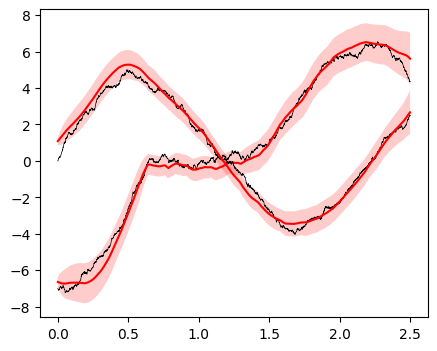

In [14]:
# plot the latent path for an example trial
trial_idx = 0
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
t_grid = jnp.arange(0, t_max, dt)
for i in range(K):
    ax.plot(t_grid,xs[trial_idx][:,i],color='black',linewidth=0.5,label='x(t)')
    ax.plot(t_grid,ms_rot[trial_idx,:,i], color='red', label='$m_x(t)$')
    ax.fill_between(t_grid, ms_rot[trial_idx,:,i]+2*jnp.sqrt(Ss_rot[trial_idx,:,i,i]),
                    ms_rot[trial_idx,:,i]-2*jnp.sqrt(Ss_rot[trial_idx,:,i,i]), facecolor='red', alpha=0.2)

In [15]:
# visualize learned dynamics
from utils import get_posterior_f_mean, get_posterior_f_var

# generate grid in true generative space
xlim = 8
n_grid = 15
X1, X2 = jnp.meshgrid(
    jnp.linspace(-xlim, xlim, n_grid),
    jnp.linspace(-xlim, xlim, n_grid)
)
Xs_rot = jnp.column_stack([X1.ravel(), X2.ravel()]) # (N**2, 2)

# rotate to gpslds inferred space
Xs = jnp.linalg.solve(P, Xs_rot.T).T 
Xs_grid = Xs.reshape(n_grid, n_grid, -1)

f_mean = get_posterior_f_mean(kernel.K, kernel_params, Xs, zs, q_u_mu)
f_mean_rot = (P @ f_mean[...,None]).squeeze(-1)

f_var = get_posterior_f_var(kernel.K, kernel_params, Xs, zs, q_u_sigma[0])
f_cov = vmap(jnp.diag)(jnp.vstack((f_var, f_var)).T)
f_cov_rot = P @ f_cov @ P.T
f_det_rot = vmap(jnp.linalg.det)(f_cov_rot)

Text(0, 0.5, '$x_2$')

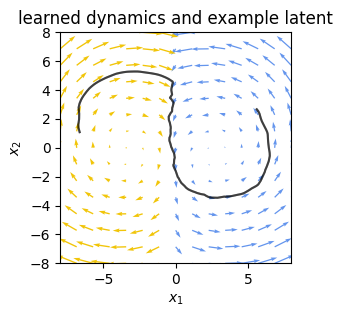

In [16]:
# learned dynamics plot
from utils import get_most_likely_state

trial_idx = 0

fig, ax = plt.subplots(figsize=(3, 3))
most_likely_state = get_most_likely_state(kernel.construct_pi, kernel_params, Xs)
colors = ["cornflowerblue", "#F1C509"]

for i in range(num_states):
    state_inds = (most_likely_state == i).astype(bool)
    ax.quiver(Xs_rot[state_inds,0], Xs_rot[state_inds,1], f_mean_rot[state_inds,0], f_mean_rot[state_inds,1], color=colors[i])
    ax.plot(ms_rot[trial_idx,:,0], ms_rot[trial_idx,:,1], 'k', alpha=0.5)
ax.set_aspect(1.)
ax.set_xlim(-xlim, xlim)
ax.set_ylim(-xlim, xlim)
ax.set_title("learned dynamics and example latent")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")

In [17]:
# compute posterior variance on a finer grid
# generate grid in true generative space
xlim = 8
n_grid_fine = 40
X1_fine, X2_fine = jnp.meshgrid(
    jnp.linspace(-xlim, xlim, n_grid_fine),
    jnp.linspace(-xlim, xlim, n_grid_fine)
)
Xs_rot_fine = jnp.column_stack([X1_fine.ravel(), X2_fine.ravel()]) # (N**2, 2)
Xs_rot_grid_fine = Xs_rot_fine.reshape(n_grid_fine, n_grid_fine, -1)

# rotate to gpslds inferred space
Xs_fine = jnp.linalg.solve(P, Xs_rot_fine.T).T 
Xs_grid_fine = Xs_fine.reshape(n_grid_fine, n_grid_fine, -1)

f_var = get_posterior_f_var(kernel.K, kernel_params, Xs_fine, zs, q_u_sigma[0])
f_cov = vmap(jnp.diag)(jnp.vstack((f_var, f_var)).T)
f_cov_rot = P @ f_cov @ P.T
f_det_rot = vmap(jnp.linalg.det)(f_cov_rot)

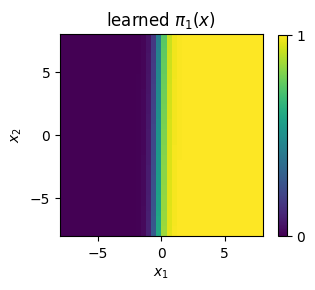

In [18]:
# learned pis plot
from utils import get_learned_pis

learned_pis = get_learned_pis(kernel.construct_pi, kernel_params, Xs_fine)
learned_pis_grid = learned_pis.reshape(n_grid_fine, n_grid_fine, -1)

fig, ax = plt.subplots(figsize=(3,3))
im = ax.imshow(learned_pis_grid[:,:,0], origin='lower', extent=[-xlim, xlim, -xlim, xlim])
ax.set_aspect(1.)
ax.set_xticks([-5, 0, 5])
ax.set_yticks([-5, 0, 5])
ax.set_title(r"learned $\pi_1(x)$")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")

fig.subplots_adjust(right=.8)
cbar_ax = fig.add_axes([0.85, 0.16, 0.03, 0.67])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks([0, 1])

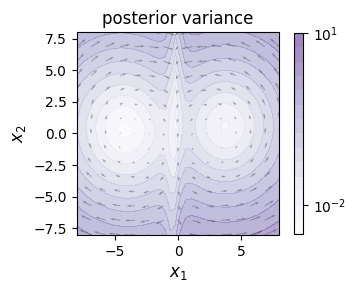

In [19]:
from matplotlib import ticker, cm

fig, ax = plt.subplots(figsize=(3, 3))

levels = 10**(jnp.linspace(-2.5, 1, 15))
contour = ax.contourf(X1_fine, X2_fine, f_det_rot.reshape(n_grid_fine, n_grid_fine), levels=levels, alpha=0.5, locator=ticker.LogLocator(), cmap='Purples')
ax.quiver(Xs_rot[:,0], Xs_rot[:,1], f_mean_rot[:,0], f_mean_rot[:,1], color='black', alpha=0.3)

ax.set_aspect(1)
ax.set_title("posterior variance", fontsize=12)
ax.set_xlabel(r"$x_1$", fontsize=12)
ax.set_ylabel(r"$x_2$", fontsize=12)

fig.subplots_adjust(right=.8)
cbar_ax = fig.add_axes([0.85, 0.16, 0.03, 0.67])
cbar = fig.colorbar(contour, cax=cbar_ax)

cbar.locator = ticker.LogLocator(10)
cbar.set_ticks([1e-2, 1e1])